# Homework 7 (Part II): Variational Autoencoder for Fashion MNIST

## Student 1: Karolina Sidlauskaite (100392576)
## Student 2: Niall O'Neill (100394545)

In this second exercise, we will learn a probabilisitc generative model for the [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist). 

<img src='fashion-mnist-sprite.png' width=500px>



Unlike the localization example, we will train both the **generative model parameters** and the parameters of the **inference variaitonal family**.

----

<img src="genmodel.png" style="width: 800px;">


---

----

<img src="infermodel.png" style="width: 800px;">

## ELBO lower-bound to $p(\mathbf{X})$

<img src="ELBO.png" style="width: 800px;">

Where $\text{KL}(q_{\eta,\mathbf{x}}(\mathbf{z})||p(\mathbf{z}))$ is known in closed form since it is the KL divergence between two Gaussian pdfs:

\begin{align}
\text{KL}(q_{\eta,\mathbf{x}}(\mathbf{z})||p(\mathbf{z})) = \frac{1}{2} \left[\text{tr}\left(\text{diag}(\sigma_{\eta}(\mathbf{x}))\right)+\left(\mu_{\eta}(\mathbf{x})^T\mu_{\eta}(\mathbf{x})\right)-2-\log\det \left(\text{diag}(\sigma_{\eta}(\mathbf{x}))\right) \right]
\end{align}

## SGD optimization

- Sample a M-size minibatch of images.
- Sample $\mathbf{\epsilon}^{(i)}$ from $\mathcal{N}(\mathbf{0},\mathbf{I})$, $i=1,\ldots,M$.
- For $i=1,\ldots,M$, compute
\begin{align}
\mathbf{z}^{(i)} = \mu_\eta(\mathbf{x}^{(i)}) + \sqrt{\text{diag}(\sigma_\eta(\mathbf{x}^{(i)}))} \circ \mathbf{\epsilon}^{(i)}
\end{align}
- Compute gradients of 
\begin{align}
\hat{\mathcal{L}}(\mathbf{X},\theta,\eta) =\sum_{i=1}^M \Big(\log  p_\theta(\mathbf{x}^{(i)}|\mathbf{z}^{(i)}) - \text{KL}(q_{\eta,\mathbf{x}^{(i)}}(\mathbf{z})||p(\mathbf{z}))\Big)
\end{align}
w.r.t. $\theta,\eta$
- Perform SGD update




In [1]:
import torch
from torch import nn
from torch import optim
from torchvision import datasets, transforms

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
%matplotlib inline

# use seaborn plotting defaults
import seaborn as sns; sns.set()

First off, let's load the dataset through torchvision.

In [2]:
# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
transforms.Normalize((0.5,), (0.5,))
])
# Download and load the training data
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

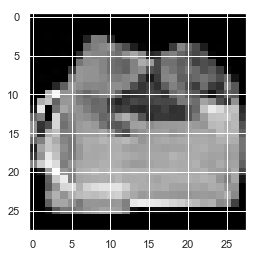

In [3]:
image, label = next(iter(trainloader))
plt.imshow(image[20,:].numpy().reshape([28,28]),cmap='gray')

### Probabilistic model definition and generating samples

We assume that all parameteres in the probabilistic model are known. To generate the sample matrix $\mathbf{X}$, we fix the target position. Our goal is to run the inference method to estimate the target position exclusively from $\mathbf{X}$.

### Steps 1 & 2 (1 point): 

#### Defintion of the NN that define the generative model (decoder)

Given $\mathbf{z}\sim\mathcal{N}(0,I)$, we will train **one** NN to estimate the mean of $p(\mathbf{x}|\mathbf{z})$.  **For simplicity, we assume a diagonal indentity covariance matrix**. 

The NN has two hidden layers with hiperbolic tangent activations and no output activation. 

#### Defintion of the NNs that define the posterior mean and covariance matrix

Given $\mathbf{X}$ (reshaped into a vector), we will train two NNs to estimate both the mean and covariance matrix of the approximation to the posterior $q(\mathbf{z}|\mathbf{X})$. We assume a diagonal covariance matrix. In this way, the NN provides the diagonal of the covariance matrix.

Each NN has two hidden layers with hiperbolic tangent activations and no output activation. Since the diagonal of the covariance matrix can only contain positive numbers, we assume the network outpus the **logarithm of the diagonal of the covariance matrix variance**.

We will use a common class to construct both the decoder and posterior moments:

In [4]:
class moments(nn.Module):
    def __init__(self,input_dim,output_dim,hidden_dims,train_cov=True):
        super().__init__()
        
        self.train_cov = train_cov
        
        # Inputs to hidden layer linear transformation
        self.hidden_mean = nn.Linear(input_dim,hidden_dims[0])
        
        self.hidden_mean_2 = nn.Linear(hidden_dims[0],hidden_dims[1])
        
        # Mean linear layer
        self.output_mean = nn.Linear(hidden_dims[1], output_dim)
        
        if(self.train_cov == True):
            self.hidden_var = nn.Linear(input_dim,hidden_dims[0])
        
            self.hidden_var_2 = nn.Linear(hidden_dims[0],hidden_dims[1])
            
            # Diagonal variance linear layer
            self.output_log_var = nn.Linear(hidden_dims[1], output_dim)

        self.activation = nn.Tanh()
                
        
    def forward(self, input_vector):
        # Pass the input tensor through each of our operations

        self.mean = self.output_mean(self.activation(
            self.hidden_mean_2(self.activation(self.hidden_mean(input_vector)))))
        
        if(self.train_cov == True):
            
            self.log_var = self.output_log_var(self.activation(self.hidden_var_2(
                self.activation(self.hidden_var(input_vector)))))  

### Step 3: Create a class to evaluate the loss function (ELBO) (2 points)

The following class creates the decoder and the inference networks, and evaluates the ELBO

In [5]:
class Variational_Loss():
    
    def __init__(self,z_dim,x_dim,hidden_dims_inference,hidden_dims_decoder,batch_size):
        
        self.z_dim = z_dim
        
        self.batch_size = batch_size
        
        # Create the decoder networs
        
        self.decoder = moments(z_dim,x_dim,hidden_dims_decoder,train_cov=False)
        
        # Create the inference networks (now we do train the covariance matrix network, so set train_cov=True)
        
        self.inference = moments(x_dim,z_dim,hidden_dims_inference,train_cov=True)
             
        
    def sample_from_q(self,x):
        
        self.inference.forward(x)
        
        # Sampling from q(z|x). 
        # We first sample from N(0,I)
        # Then, scale by std vector and sum the mean (they are contained in the self.inference class)
        
        noise = torch.FloatTensor(x.shape[0], self.z_dim).normal_()
        
        self.sample = self.inference.mean + torch.exp(self.inference.log_var.diagonal())**0.5* noise
          
    def generative_sample(self):
        
        # Generate a batch of samples from the generative model
        
        prior_sample = torch.FloatTensor(self.batch_size, self.z_dim).normal_()
        
        self.decoder.forward(prior_sample)
    
    def ELBO(self,x):
    
        self.sample_from_q(x)
        
        # KL divergence ELBO regularizer
        
        self.KL = -0.5*torch.log(torch.exp(self.inference.log_var.diagonal().prod()))+0.5*torch.sum(
                torch.exp(self.inference.log_var)+self.inference.mean**2-self.inference.log_var.diagonal())
        
        # Evaluate log-likelihood for the current z sample
        # To do this we use the probabilistic model p(x|z)!

        self.decoder.forward(self.sample)
        
        output_variance = 1. #Identity covariance matrix
        
        log_lik = -0.5 * (x-self.decoder.mean)**2/output_variance
    
        self.log_lik = torch.sum(log_lik)
    
        self.ELBO_loss = - (self.log_lik - self.KL)
        
        return self.ELBO_loss
        
        

### Step 4: Create a class to perform ELBO optimization (2 points)

Create a new class inherited from `Variational_Loss` that implements a method to perform a SGD step over the variational bound (ELBO)

In [6]:
class VAE(Variational_Loss):
    
    def __init__(self,z_dim,x_dim,hidden_dims_inference,hidden_dims_decoder,batch_size):
        
        super().__init__(z_dim,x_dim,hidden_dims_inference,hidden_dims_decoder,batch_size)
        
        # Inference Network optimizer
        
        self.optimizer_inf = optim.Adam(self.inference.parameters(),lr=1e-4)
        
        # Decoder Network optimizer
        
        self.optimizer_dec = optim.Adam(self.decoder.parameters(),lr=1e-4)
                
        
    # One SGD 
    def SGD_step(self,x):
        
        self.optimizer_inf.zero_grad()
        
        self.optimizer_dec.zero_grad()
        
        loss = self.ELBO(x)
        
        loss.backward()
        
        self.optimizer_inf.step()
        
        self.optimizer_dec.step()
    

### Step 5: Training the inference model (1 point)

In [7]:
hidden_dims_inference = [50, 100]

hidden_dims_decoder = [100, 50]

z_dim = 2

x_dim = 28**2

myvae = VAE(z_dim,x_dim,hidden_dims_inference,hidden_dims_decoder,64)

In [8]:
epochs = 10

period_plot = 1

for e in range(epochs):
    running_loss = 0
    
    for images, labels in trainloader:
        # Flatten images into a 784 long vector
        images = images.view(images.shape[0], -1)
        
        # SGD step
        
        myvae.SGD_step(images)

    if(e % period_plot == 0):
        
        print("Epoch = %d, loglik = %.5f, KL = %.5f, ELBO = %.5f" 
              %(e,myvae.log_lik,myvae.KL,myvae.ELBO_loss))

        

Epoch = 0, loglik = -2449.77686, KL = 157.40398, ELBO = 2607.18091
Epoch = 1, loglik = -2264.76074, KL = 164.26208, ELBO = 2429.02295
Epoch = 2, loglik = -2037.32642, KL = 160.32848, ELBO = 2197.65479
Epoch = 3, loglik = -2043.86304, KL = 179.01149, ELBO = 2222.87451
Epoch = 4, loglik = -1696.05566, KL = 178.25513, ELBO = 1874.31079
Epoch = 5, loglik = -1617.43030, KL = 185.87889, ELBO = 1803.30920
Epoch = 6, loglik = -1742.19104, KL = 179.43257, ELBO = 1921.62366
Epoch = 7, loglik = -2007.86707, KL = 187.16789, ELBO = 2195.03491
Epoch = 8, loglik = -1538.52954, KL = 187.91676, ELBO = 1726.44629
Epoch = 9, loglik = -1753.39233, KL = 178.21690, ELBO = 1931.60925


### Step 6: plot some images and their reconstruction (1 point)

For a given image $\mathbf{x}$, take the mean $\tilde{\mathbf{z}}$ of $q(\mathbf{z}|\mathbf{x})$ and use it as input to the decoder network. The following code compares both $\mathbf{x}$ and the mean of $p(\mathbf{x}|\tilde{\mathbf{z}})$.

torch.Size([64, 1, 28, 28])
torch.Size([64, 784])


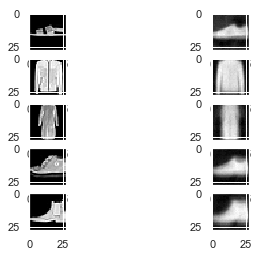

In [32]:
n_plots_axis=5

f2, axarr2 = plt.subplots(n_plots_axis,2)

images, label = next(iter(trainloader))
images = images.view(images.shape[0], -1)

myvae.inference.forward(images)
myvae.decoder.forward(myvae.inference.mean)
for i in range(n_plots_axis):

    axarr2[i,0].imshow(images[i,:].numpy().reshape([28,28]),cmap='gray');
    axarr2[i,1].imshow(myvae.decoder.mean.detach().numpy()[i,:].reshape([28,28]), cmap='gray') 
    

### Step 7: Latent projection of images (1 point)

The following code plots in the latent 2-D space a minibatch of train images

In [34]:
def plot_latent_space_with_images(ax,recons_images,z_samples):
    
    ax.clear()
    for i in range(len(recons_images)):
        im = OffsetImage(recons_images[i].reshape([28,28]), zoom=1,cmap='gray')
        ab = AnnotationBbox(im, z_samples[i],frameon=True)
        ax.add_artist(ab)
    ax.set_xlim(np.min(z_samples[:,0])-1,np.max(z_samples[:,0])+1)
    ax.set_ylim(np.min(z_samples[:,1])-1,np.max(z_samples[:,1])+1)
    ax.set_title('Latent space Z with Images')

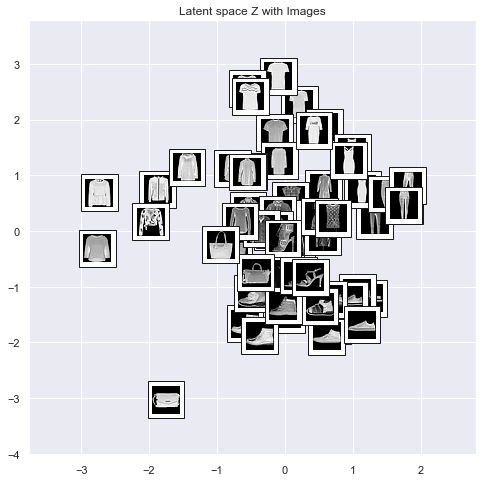

In [45]:
f_latent, ax_latent = plt.subplots(1,1,figsize=(8, 8))
plot_latent_space_with_images(ax_latent,images,myvae.inference.mean.detach().numpy()) 

### Step 8: Generate new images from the probabilistic model (1 point)

Use the method `generative_sample` to generate new images

In [50]:
myvae.generative_sample()

new_images = myvae.decoder.mean.detach().numpy()

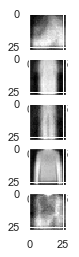

In [51]:
n_plots_axis=5

f3, axarr3 = plt.subplots(n_plots_axis,1)

for i in range(n_plots_axis):

    axarr3[i].imshow(new_images[i,:].reshape([28,28]),cmap='gray')

### Step 9: train a new VAE with larger latent dimension (1 point)

Evaluate if the quality of generated images and the reconstruction quality improves if we increase the dimensionality of the latent space.

Epoch = 0, loglik = -3131.43750, KL = 155.90002, ELBO = 3287.33740
Epoch = 1, loglik = -2529.29565, KL = 163.45917, ELBO = 2692.75488
Epoch = 2, loglik = -2304.81543, KL = 162.00421, ELBO = 2466.81958
Epoch = 3, loglik = -2360.66602, KL = 169.72069, ELBO = 2530.38672
Epoch = 4, loglik = -1992.35217, KL = 176.75357, ELBO = 2169.10571
Epoch = 5, loglik = -1723.32092, KL = 176.37814, ELBO = 1899.69910
Epoch = 6, loglik = -1669.24353, KL = 174.43193, ELBO = 1843.67542
Epoch = 7, loglik = -1877.13599, KL = 179.60118, ELBO = 2056.73706
Epoch = 8, loglik = -2004.13208, KL = 180.56735, ELBO = 2184.69946
Epoch = 9, loglik = -1541.73633, KL = 177.31845, ELBO = 1719.05481


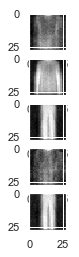

In [53]:
hidden_dims_inference_new = [50, 500]

hidden_dims_decoder_new = [500, 50]

z_dim = 2

x_dim = 28**2

new_vae = VAE(z_dim,x_dim,hidden_dims_inference,hidden_dims_decoder,64)

epochs = 10

period_plot = 1

for e in range(epochs):
    running_loss = 0
    
    for images, labels in trainloader:
        # Flatten images into a 784 long vector
        images = images.view(images.shape[0], -1)
        
        # SGD step
        
        new_vae.SGD_step(images)

    if(e % period_plot == 0):
        
        print("Epoch = %d, loglik = %.5f, KL = %.5f, ELBO = %.5f" 
              %(e,new_vae.log_lik,new_vae.KL,new_vae.ELBO_loss))

new_vae.generative_sample()

new_images = new_vae.decoder.mean.detach().numpy()

n_plots_axis=5

f3, axarr3 = plt.subplots(n_plots_axis,1)

for i in range(n_plots_axis):

    axarr3[i].imshow(new_images[i,:].reshape([28,28]),cmap='gray')